In [1]:
%config InlineBackend.figure_formats = ['svg']

import numpy as np

from llms_for_dummies.plots import plot_pe_properties, plot_sinusoidal_wavelengths, plot_pe_heatmap, plot_pe_rotation

rng = np.random.default_rng(seed=42)

# Permutation Equivariance
This is the key concept that motivates the need for positional encodings. To develop an intuition for the concept, let's first answer whether humans are permutation equivariant.

## Are Humans Permutation Equivariant?

Let $f(x)$ denote a function that takes a natural language query $x$ and produces a "human-like" natural language response $y$. Let's consider $x$ to be the sentence
* $x=[\text{The}, \text{developer}, \text{deployed}, \text{the}, \text{agent}, \text{to}, \text{production}]$

A "human-like" response would be something along the lines of $y=[\text{Cool}, \text{which}, \text{framework}, \text{did}, \text{she}, \text{use}, \text{?}]$.

Now, let's permute $x$:
* $x'=[\text{The}, \text{agent}, \text{deployed}, \text{the}, \text{developer}, \text{to}, \text{production}]$

A natural response would be $y'=[\text{What}, \text{the}, \text{heck}, \text{?}, \text{Did}, \text{AI}, \text{already}, \text{take}, \text{over}, \text{?}]$. 

If a human was permutation equivariant, we'd expect their response to be permuted in the same way as the input is permuted. This means $f(x')$ would have to be $[\text{Cool}, \text{she}, \text{framework}, \text{did}, \text{which}, \text{use}, \text{?}]$. 

This is clearly not what we want. If the input is permuted, we want a response that captures the semantic difference not merely the permutation.

## Permutation Matrices

A **permutation matrix** $P$ is a square matrix with exactly one 1 in each row and column (all other entries 0). Left-multiplying $P \cdot X$ reorders the rows of $X$ according to where those 1s sit.

The identity matrix $I$ is the special case where every 1 sits on the diagonal — each row maps to itself, so nothing changes. Moving a 1 off the diagonal causes the corresponding rows to swap:

In [2]:
N = 7

def mat_lines(arr, title, col_prefix="col", val_fmt="{:2d}", swapped=set()):
    col_w = len(val_fmt.format(0)) + 2
    header = "          " + "".join(f"{col_prefix} {j}".rjust(col_w) for j in range(arr.shape[1]))
    lines = [title, header]
    for i, row in enumerate(arr):
        vals = "  ".join(val_fmt.format(v) for v in row)
        tag = "  <- swapped" if i in swapped else ""
        lines.append(f"  row {i}:  [ {vals} ]{tag}")
    return lines

def print_side_by_side(left, right, gap=6):
    width = max(len(l) for l in left)
    for l, r in zip(left, right):
        print(l.ljust(width + gap) + r)

I = np.eye(N, dtype=int)
P = np.eye(N, dtype=int)
P[[1, 4]] = P[[4, 1]]  # swap rows 1 and 4

left  = mat_lines(I, "Identity I  (no change)")
right = mat_lines(P, "Permutation P  (rows 1 & 4 of X will be swapped when we perform PX)", swapped={1, 4})

print_side_by_side(left, right)

Identity I  (no change)                            Permutation P  (rows 1 & 4 of X will be swapped when we perform PX)
          col 0col 1col 2col 3col 4col 5col 6                col 0col 1col 2col 3col 4col 5col 6
  row 0:  [  1   0   0   0   0   0   0 ]             row 0:  [  1   0   0   0   0   0   0 ]
  row 1:  [  0   1   0   0   0   0   0 ]             row 1:  [  0   0   0   0   1   0   0 ]  <- swapped
  row 2:  [  0   0   1   0   0   0   0 ]             row 2:  [  0   0   1   0   0   0   0 ]
  row 3:  [  0   0   0   1   0   0   0 ]             row 3:  [  0   0   0   1   0   0   0 ]
  row 4:  [  0   0   0   0   1   0   0 ]             row 4:  [  0   1   0   0   0   0   0 ]  <- swapped
  row 5:  [  0   0   0   0   0   1   0 ]             row 5:  [  0   0   0   0   0   1   0 ]
  row 6:  [  0   0   0   0   0   0   1 ]             row 6:  [  0   0   0   0   0   0   1 ]


## Is Attention Permutation Equivariant?

A function $f$ is permutation equivariant if for any permutation matrix $P$:

$$f(PX) = P \cdot f(X)$$

Shuffle the input rows, and the output rows are shuffled in exactly the same way. Let's see:

In [3]:
def attention(X):
    rng = np.random.default_rng(seed=42)
    W_q = rng.random(size=(d_model, d_head))
    W_k = rng.random(size=(d_model, d_head))
    W_v = rng.random(size=(d_model, d_head))

    Q = X @ W_q
    K = X @ W_k
    V = X @ W_v

    S = (Q @ K.T) / np.sqrt(d_head)
    exp_S = np.exp(S - np.max(S, axis=1, keepdims=True))
    A = exp_S / np.sum(exp_S, axis=1, keepdims=True)
    
    return A @ V

In [4]:
N, d_model, d_head = 7, 4, 4

x = np.random.rand(N, d_model)

y   = attention(x)      # original
y_p = attention(P @ x)  # permuted input

def pprint(arr, title, highlight={1, 4}):
    header = "          " + "".join(f"   dim {j}" for j in range(arr.shape[1]))
    print(title)
    print(header)
    print("    ...")
    for i in sorted(highlight):
        vals = "  ".join(f"{v:6.3f}" for v in arr[i])
        print(f"  row {i}:  [ {vals} ]  <- swapped")
        print("    ...")
    print()

pprint(y,   "Attention(x)  — original:")
pprint(y_p, "Attention(Px) — permuted input:")

print(f"Attention(Px) == P · Attention(x): {np.allclose(y_p, P @ y)}")

Attention(x)  — original:
             dim 0   dim 1   dim 2   dim 3
    ...
  row 1:  [  0.759   1.247   0.932   0.789 ]  <- swapped
    ...
  row 4:  [  0.803   1.339   0.992   0.875 ]  <- swapped
    ...

Attention(Px) — permuted input:
             dim 0   dim 1   dim 2   dim 3
    ...
  row 1:  [  0.803   1.339   0.992   0.875 ]  <- swapped
    ...
  row 4:  [  0.759   1.247   0.932   0.789 ]  <- swapped
    ...

Attention(Px) == P · Attention(x): True


Attention **is** permutation equivariant. Shuffle the tokens in, get the same representations back — just reordered.

But recall from the opening: this is exactly the property we *don't* want. Rearranging *"The developer deployed the agent"* into *"The agent deployed the developer"* should produce a fundamentally different response, not a permuted version of the same one.

# Positional Encodings

This is why transformers need **positional encodings (PE)** — a way to stamp each token with its position *before* attention runs, so that order is no longer invisible.

In other words, we need something akin to

* $x_{\text{pos-encoded}}=[\text{The}_1, \text{developer}_2, \text{deployed}_3, \text{the}_4, \text{agent}_5, \text{to}_6, \text{production}
_7]$

The original permutation would then look like:

* $x'_{\text{pos-encoded}}=[\text{The}_1, \text{agent}_2, \text{deployed}_3, \text{the}_4, \text{developer}_5, \text{to}_6, \text{production}
_7]$

We enrich the word with information about its position. This way the same word will have a different representation depending on its location in the sequence (e.g., $\text{agent}_5 \neq \text{agent}_2$). 

## What We Need from a Positional Encoding

In this notebook's context (there can be alternative encodings that'll function in other ways), we're interested in a function $PE(\text{pos})$ that maps each position to a $d$-dimensional vector. The PEs we explore in this notebook are all **additive** — they are added to the token embeddings before attention: $x_\text{pos} = \text{emb}(x) + PE(\text{pos})$. With that in mind, here are the properties we want:

| Property | What good looks like |
|----------|----------------------|
| **Embedding compatibility** | Norm of embedding matrix stays roughly flat after adding PE |
| **Translation invariance** | $PE(\text{pos}) \cdot PE(\text{pos}+k)$ is constant across $\text{pos}$ |
| **Proximity** | Similarity decreases with distance between positions |
| **Unique** per position | Every position has a distinct vector |
| **Generalizes** to unseen lengths | Formula extends beyond training length |

In the following, proximity will be tested with two complementary views: a **heatmap** of the full $N \times N$ similarity matrix (where a clear diagonal band means nearby positions are similar), and **anchor curves** that pick a few fixed positions and plot their similarity to every other position (a good PE produces curves that peak at the anchor and decay with distance).

Let's test two naive approaches against this checklist.

### Absolute PE: $PE(\text{pos}) = \text{pos}$

The simplest idea: use the raw position index broadcast across all embedding dimensions. Our embeddings live in $[0, 1]$, so ideally PE values would be in a similar range — but position indices go from $0$ to $N-1$, with no normalization. Let's see what that means in practice.

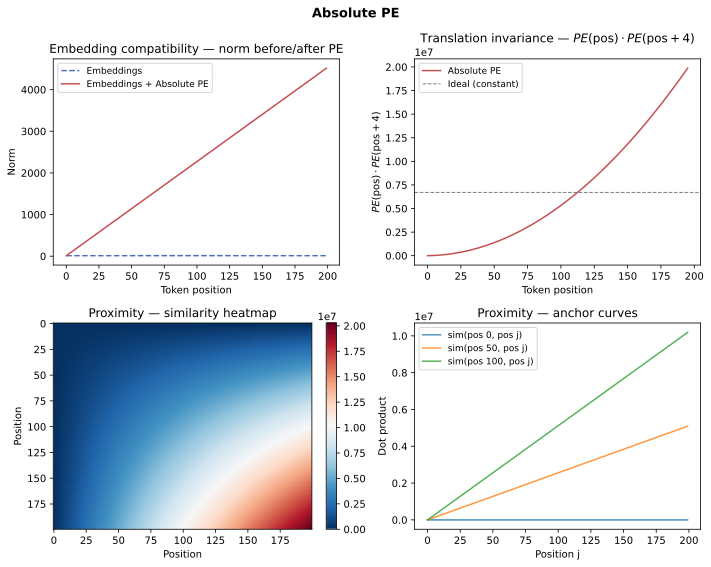

In [5]:
N, model_dim = 200, 512

base_embeds = rng.random(size=(N, model_dim))
abs_pe_vecs = np.arange(N).reshape(N, 1) * np.ones((N, model_dim))  # (N, d)

plot_pe_properties(base_embeds, abs_pe_vecs, label="Absolute PE", gap=4)

| Property | Result |
|----------|--------|
| **Embedding compatibility**: does the norm stay stable? | ❌ norm grows linearly with position, swamping the semantic signal |
| **Translation invariance**: should be a flat line | ❌ $PE(\text{pos}) \cdot PE(\text{pos}+4)$ grows with $\text{pos}$; "4 apart" means something very different at position 2 vs position 90 |
| **Proximity**: similarity should decrease with distance | ❌ similarity grows with absolute position, not proximity — heatmap has no diagonal and anchor curves increase monotonically, peaking at the last position |
| **Unique** per position | ✅ each integer index is distinct by definition |
| **Generalizes** to unseen lengths | ❌ positions beyond training length are entirely out of distribution |

## Building Intuition: Binary Counting

Before jumping to the definition of sinusoidal PE, let's look at a familiar system that encodes integers: **binary representation**.

Think about a 4-bit binary counter (0–15). Each bit oscillates at a different frequency:

- **bit0** (rightmost) flips every step — frequency = 1
- **bit1** flips every 2 steps — frequency = 1/2
- **bit2** flips every 4 steps — frequency = 1/4
- **bit3** flips every 8 steps — frequency = 1/8

Each bit oscillates at a different frequency, and together they uniquely identify every position. **This is a positional encoding!** Each "dimension" (bit) captures position information at a different resolution — fast-changing bits give fine-grained position, slow-changing bits give coarse position.

### Binary PE

Binary PE (as described above and implemented below) trivially satisfies **Unique** (every integer has a distinct bit pattern) and **Embedding compatibility** (values in $\{0, 1\}$ keep norms bounded). Let's check the remaining three properties with the same plots.

In [6]:
def binary_pe(max_len, d_model):
    """Binary positional encoding — dimension i is bit i of the position's binary representation.

    Requires d_model >= log2(max_len) to uniquely encode all positions.
    Returns: (max_len, d_model) array of 0s and 1s.
    """
    pe = np.zeros((max_len, d_model))
    positions = np.arange(max_len)
    for i in range(d_model):
        # >> i  : right-shift by i, discarding the i lowest bits
        # & 1   : keep only the new lowest bit → extracts bit i
        # e.g. pos=6 (0b110): i=0 → 0,  i=1 → 1,  i=2 → 1
        pe[:, i] = (positions >> i) & 1
    return pe

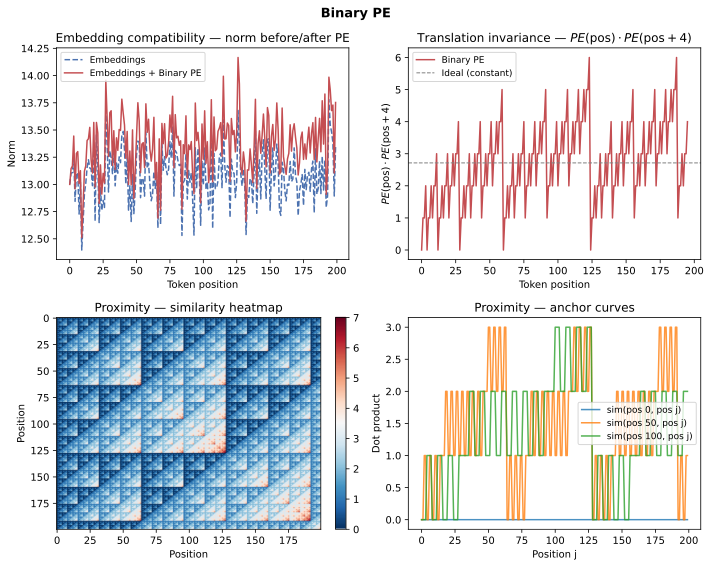

In [7]:
binary_pe_vecs = binary_pe(N, model_dim)

plot_pe_properties(base_embeds, binary_pe_vecs, label="Binary PE", gap=4)

| Property | Result |
|----------|--------|
| **Embedding compatibility**: does the norm stay stable? | ✅ values in $\{0, 1\}$ are in the same range as the embeddings, so adding PE doesn't overwhelm the token signal at any position |
| **Translation invariance**: should be a flat line | ❌ erratic; binary carries create discontinuous jumps at powers-of-2 boundaries |
| **Proximity**: similarity should decrease with distance | ❌ heatmap shows a fractal checkerboard instead of a diagonal band; anchor curves jump erratically rather than decaying smoothly. Adjacent positions can share zero bits while distant ones share many (e.g. `0111` and `1000`, positions 7 and 8, share no 1-bits so their dot product is 0, yet PE(7) · PE(3) = 2) |
| **Unique** per position | ✅ every position has a distinct bit pattern |
| **Generalizes** to unseen lengths | ❌ the pattern extends trivially, but the broken distance structure persists |

## Sinusoidal Positional Encoding

Binary PE had the right idea: assign each dimension a different oscillation frequency so that the combination of values uniquely identifies every position. The problem was discreteness — the sharp 0/1 transitions and binary carries make the dot product a poor similarity measure.

The fix is to replace the square waves with **sinusoids**. The [original transformer paper](https://arxiv.org/pdf/1706.03762) proposes:

$$PE(\text{pos}, 2i) = \sin\!\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right), \qquad PE(\text{pos}, 2i+1) = \cos\!\left(\frac{\text{pos}}{10000^{2i/d_{\text{model}}}}\right)$$

where $\text{pos}$ is the token position and $i$ indexes the sin/cos pairs — pair $i$ occupies dimensions $2i$ and $2i+1$, so $d_{\text{model}}/2$ pairs cover all dimensions. The base $10000$ controls the spread of wavelengths: a larger base stretches the range from the shortest to the longest wavelength. As $i$ increases, each dimension oscillates more slowly — the plot below shows this for a few values of $i$ and three choices of base:

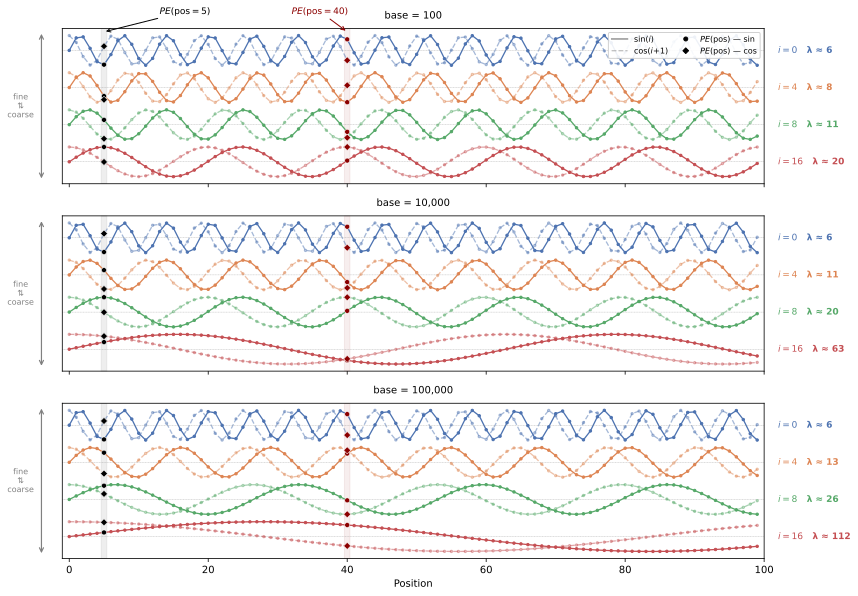

In [8]:
plot_sinusoidal_wavelengths(
    bases=(100, 10000, 100000),
    dim_pairs=(0, 4, 8, 16),
    d_model=128,
    n_positions=100,
    highlight_pos=(5, 40),
)

This is exactly binary counting made continuous — slow dimensions for global structure, fast dimensions for local detail, but now smooth enough that the dot product reflects similarity. Note, that we introduced shifts on the y-axis for legibility.

Let's check sinusoidal PE against our checklist with the same plots:

In [9]:
def sinusoidal_pe(max_len, d_model):
    """Generate sinusoidal positional encoding matrix.
    
    Returns: (max_len, d_model) array where each row is the encoding for that position.
    """
    pe = np.zeros((max_len, d_model))
    pos = np.arange(max_len)[:, np.newaxis]          # (max_len, 1)
    i = np.arange(0, d_model, 2)[np.newaxis, :]      # (1, d_model/2)
    
    # Frequencies decrease geometrically: 1, 1/10000^(2/d), 1/10000^(4/d), ...
    angles = pos / np.power(10000, i / d_model)       # (max_len, d_model/2)
    
    pe[:, 0::2] = np.sin(angles)  # Even dimensions
    pe[:, 1::2] = np.cos(angles)  # Odd dimensions
    
    return pe

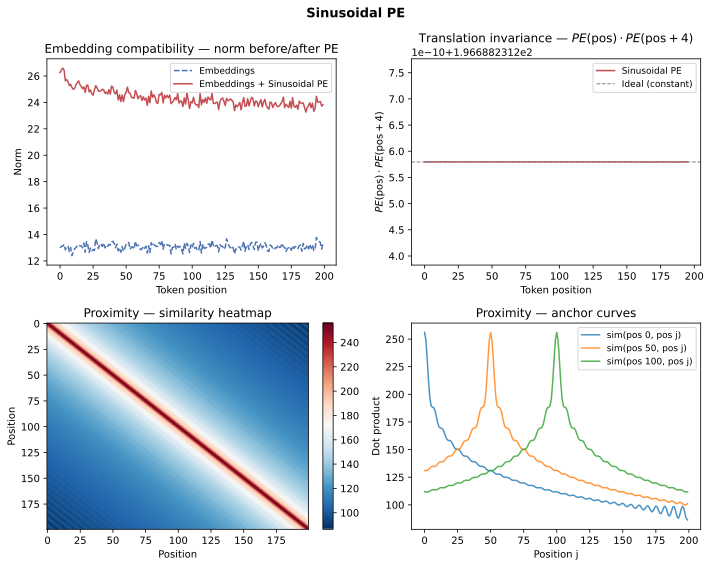

In [10]:
sinusoidal_pe_vecs = sinusoidal_pe(N, model_dim)

plot_pe_properties(base_embeds, sinusoidal_pe_vecs, label="Sinusoidal PE", gap=4)

| Property | Result |
|----------|--------|
| **Embedding compatibility**: does the norm stay stable? | ✅ norm stays roughly flat across all positions; PE doesn't overwhelm the token signal, it just shifts it |
| **Translation invariance**: should be a flat line | ✅ $PE(\text{pos}) \cdot PE(\text{pos}+4)$ is essentially constant, hugging the ideal dashed line |
| **Proximity**: similarity should decrease with distance | ✅ clear diagonal banding; anchor curves peak at the anchor position and taper off smoothly with distance |
| **Unique** per position | ✅ each position's sin/cos combination is distinct by construction |
| **Generalizes** to unseen lengths | ☑️ the deterministic formula extends to any length without modification; empirically works well up to ~2× training length |

All five checks pass. Let's look more closely at *what* the sinusoidal PE matrix actually looks like and why this multi-frequency structure gives the model such clean distance information.

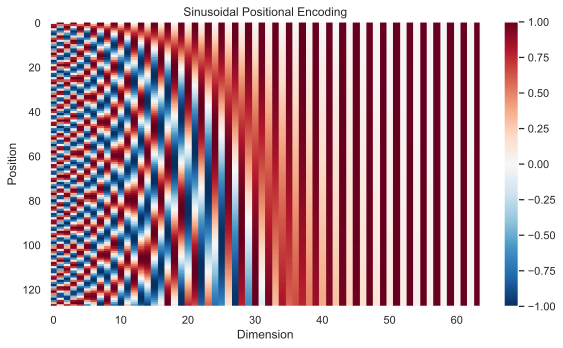

In [11]:
max_len, d_model = 128, 64
pe = sinusoidal_pe(max_len=max_len, d_model=d_model)

plot_pe_heatmap(
    pe=pe,
    max_len=max_len,
    d_model=d_model,
)

### Relative Position via Linear Transformation

We just showed that sinusoidal PE passes the **translation invariance** check: $PE(\text{pos}) \cdot PE(\text{pos}+k)$ is constant across $\text{pos}$ for a fixed offset $k$. In other words, the similarity between two positions depends on *how far apart* they are, not on *where* they sit. This is a great property but why does it hold?

For any fixed offset $k$, there exists a matrix $T_k$ such that:

$$PE(\text{pos} + k) = T_k \cdot PE(\text{pos})$$

**Why?** Consider a single sin/cos pair at frequency $\omega_i = 1/10000^{2i/d_{\text{model}}}$. At position $\text{pos}$, this pair produces the 2D vector $(\sin(\omega_i \cdot \text{pos}),\; \cos(\omega_i \cdot \text{pos}))$ — a point on the unit circle at angle $\theta = \omega_i \cdot \text{pos}$. Advancing by $k$ positions adds $\omega_i \cdot k$ to that angle, which is just a **rotation** of the point around the circle.

A 2D rotation by a fixed angle $\phi = \omega_i \cdot k$ is a matrix multiply:

$$\begin{bmatrix} \sin(\theta + \phi) \\ \cos(\theta + \phi) \end{bmatrix} = \underbrace{\begin{bmatrix} \cos\phi & \sin\phi \\ -\sin\phi & \cos\phi \end{bmatrix}}_{T_k^{(i)}} \begin{bmatrix} \sin\theta \\ \cos\theta \end{bmatrix}$$

The full PE vector is $d_{\text{model}}/2$ of these pairs stacked together. Each pair lives in its own 2D plane, and $T_k$ rotates each one independently — it is **not** a single rotation of the full $d$-dimensional vector, but $d_{\text{model}}/2$ separate 2D rotations happening in parallel, each at its own speed $\omega_i$. This makes $T_k$ a block-diagonal matrix of $2 \times 2$ rotation blocks. Crucially, $T_k$ depends only on the offset $k$, not on the absolute position.

**Why this gives translation invariance.** Substituting $PE(\text{pos}+k) = T_k \cdot PE(\text{pos})$ into the dot product:

$$PE(\text{pos})^\top \cdot PE(\text{pos}+k) = PE(\text{pos})^\top \cdot T_k \cdot PE(\text{pos})$$

At first glance this still depends on $\text{pos}$ through $PE(\text{pos})$. But two properties of the sinusoidal construction make it cancel out:

1. **Every PE vector has the same norm.** Each sin/cos pair $(\sin\theta, \cos\theta)$ sits on the unit circle, so $\|PE(\text{pos})\|^2 = d_{\text{model}}/2$ for all $\text{pos}$. (Try to convince yourself why (hint: how many pairs are there, and what is the norm of each?))

2. **$T_k$ is orthogonal** (each block is a rotation). Rotation matrices preserve lengths and angles — they don't stretch or squash, they only rotate.

Together: $PE(\text{pos})^\top T_k \, PE(\text{pos})$ is measuring how much a vector aligns with a rotated version of itself. Since all PE vectors have the same norm and $T_k$ rotates each 2D pair by a fixed angle, the alignment depends only on those rotation angles — which are determined by $k$ alone, not by $\text{pos}$. Changing $\text{pos}$ just spins each pair to a different starting point on its unit circle, but the *angle between* the original and rotated point stays the same.

This is exactly the translation invariance we observed in the plots.

Let's visualize this. Each panel below shows one sin/cos pair as a point on its own unit circle. Advancing by $k = 7$ rotates each pair by a different angle $\phi_i = \omega_i \cdot k$:

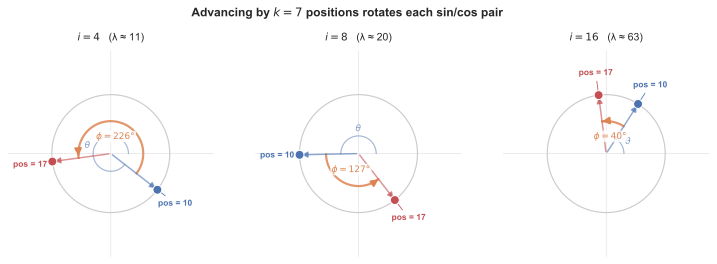

In [12]:
plot_pe_rotation(
    pos=10,
    k=7,
    dim_pairs=(4, 8, 16),
    d_model=128,
)

Each panel is one 2×2 block of $T_k$. For frequency index $i$, the rotation angle is $\phi_i = \omega_i \cdot k$:

$$T_k^{(i=4)} = \begin{bmatrix} -0.70 & -0.71 \\ +0.71 & -0.70 \end{bmatrix} \quad \phi = 226° \qquad T_k^{(i=8)} = \begin{bmatrix} -0.60 & +0.80 \\ -0.80 & -0.60 \end{bmatrix} \quad \phi = 127° \qquad T_k^{(i=16)} = \begin{bmatrix} +0.76 & +0.64 \\ -0.64 & +0.76 \end{bmatrix} \quad \phi = 40°$$

Low $i$ → fast frequency → large rotation per step. High $i$ → slow frequency → small rotation. The full $T_k$ stacks all $d_{\text{model}}/2$ of these blocks along the diagonal — each pair rotates independently, and all zeros elsewhere.

### How to "learn" to attend to a token k positions away

We showed above that shifting a position by $k$ is a linear transformation of the PE vector. This is never used in the actual computation — it's an analytical property of the sinusoidal formula that helps us understand *why* attention heads can learn to attend to relative positions. Let's see how.

Consider a single attention head. The pre-softmax & pre-scaling attention score (i.e., dot product similarity) between a query at position $\text{pos}$ and a key at position $\text{pos}+k$ is:

$$\text{score} = q_\text{pos} \, k_{\text{pos}+k}^\top = (x_\text{pos} W_Q)(x_{\text{pos}+k} W_K)^\top$$

where $x_\text{pos} = \text{emb}(x) + PE(\text{pos})$ is the token embedding plus positional encoding. Let's ignore the token embedding for a moment and focus purely on the PE contribution:

$$\text{score}_{\text{PE}} = (PE(\text{pos}) \cdot W_Q)(PE(\text{pos}+k) \cdot W_K)^\top$$

The model only ever computes $PE(\text{pos}) \cdot W_Q$ and $PE(\text{pos}+k) \cdot W_K$ separately and dots them together — no $T_k$ matrix is involved. But we can use the linear transformation property to *analyze* what the model is implicitly doing:

$$\text{score}_{\text{PE}} = PE(\text{pos})^\top \underbrace{W_Q W_K^\top}_{W_{QK}} \underbrace{T_k}_{} PE(\text{pos})$$

This reveals that the effective score factorizes into a learned part ($W_{QK} = W_Q W_K^\top$) and a fixed part ($T_k$). Since $T_k$ depends only on the offset $k$, the model can learn $W_Q$ and $W_K$ such that $W_{QK} T_k$ produces a large score for the offset $k$ it wants to attend to, and a small score for other offsets.

Concretely, if a head wants to always look $k=3$ tokens back (e.g., to relate a verb to its subject), it can learn query and key projections where $W_{QK} \approx T_3^\top$. Then at offset $k=3$: $W_{QK} T_3 \approx T_3^\top T_3 = I$ (because $T_3$ is orthogonal), and the score becomes $PE(\text{pos})^\top I \, PE(\text{pos}) = \|PE(\text{pos})\|^2$ — a vector dotted with itself, the maximum possible value.

### The Limitations of a Single Head
Note an important consequence: a single head's $W_Q, W_K$ produce the same relative-position bias at every position in the sequence. A head *cannot* learn "look 3 tokens back for early positions and 10 tokens back for late positions" — it commits to one offset pattern uniformly. This is the flip side of translation invariance: you get consistent relative attention, but no position-dependent offsets within a single head. In practice, the model works around this by using **multiple heads** — different heads specialize in different offsets, and subsequent layers combine their outputs.

### How Sinusoidal PE Is Used

In the original transformer, the positional encoding is **added** to the token embeddings before they enter attention:

$$\text{Input} = \text{TokenEmbedding}(x) + PE$$

Both have the same shape — $(\text{seq\_len}, d_{\text{model}})$ — so the addition is elementwise. Note that this is a design choice specific to sinusoidal (and other additive) PEs — not all positional encodings work this way.

## Sinusoidal PE & Permutation Equivariance

In [13]:
# Let's verify that adding PE breaks the permutation equivariance
N, d_model, d_head = 7, 4, 4

x = np.random.rand(N, d_model)
pe = sinusoidal_pe(N, d_model)

# If attention were still permutation equivariant, we'd expect:
#   attention(P @ x + pe) == P @ attention(x + pe)
# i.e., un-permuting the output should recover the original

print(f"Without PE: Attention(Px) == P · Attention(x): {np.allclose(attention(P@x), P@attention(x))}")
print(f"With PE:    Attention(Px + pe) == P · Attention(x + pe): {np.allclose(attention(P@x + pe), P@attention(x + pe))}")


Without PE: Attention(Px) == P · Attention(x): True
With PE:    Attention(Px + pe) == P · Attention(x + pe): False


The outputs are now different — attention is position-aware!

Why? Swapping rows 1 and 4 moves tokens to new positions,
where they receive different PE vectors. The same token gets
a different encoding depending on where it sits in the sequence.

## Conclusion and Outlook

Sinusoidal PE solved the core problem: it gives attention access to token order via a fixed, deterministic encoding that is unique per position, compatible with embeddings, and — thanks to its multi-frequency sinusoidal structure — encodes relative distance in a way that learned query/key projections can exploit.

But it has a fundamental design choice baked in: position information is **added** to the token embedding before attention. This means PE influences queries, keys, *and* values equally, and the model must learn to disentangle "where" from "what" through $W_Q$, $W_K$, and $W_V$ alone.

What if we applied the rotation idea *directly* inside attention — rotating queries and keys by their position rather than adding a position signal to the input? That's exactly what **Rotary Position Embeddings (RoPE)** do, and it's what we'll explore next.